# Third assignment: Social contagion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools

import plotly 
plotly.tools.set_credentials_file(username='franco.danilo', api_key='ecMyRQ2GXo5ZASr8AgFu')

import plotly.plotly as py
import plotly.graph_objs as go

In this assignment, we inspect the diffusion of social contagion.
We use different graphs: the Davis southern women graph, different kind of random graphs (varying the probability of having an edge between nodes), a scale-free graph and a real graph (arXiv collaboration on general relativity).

We try to spread the infection both from a random starting point and from high centrality nodes, using different centrality index, in order to see the differences and make observations about the behaviour.

## 0. Contagion utilities definitions

In [12]:
def init_labels(graph):
    labels={}
    for node in graph.nodes():
        labels[node] = 'b'
    return labels

def susceptibleList(labeledNodes):
    return [k for k,v in labeledNodes.items() if v=='b']

def node_neighbourhood(graph):
    neig = {}
    
    for node in graph.nodes():
        neig[node]=[]
        
    for i,j in graph.edges():
        neig[i].append(j)
        neig[j].append(i)
    
    return neig

def spread_contagion(neigbours, labeledNodes, decisionPO, verbose=False):
    i = 1
    changed = 0
    
    while True:
        current = list(labeledNodes.values())
        susc = susceptibleList(labeledNodes)
        
        for node in susc:            
             
            num_neigb = len(neigbours[node])
            infct_neigb = len([friend for friend in neigbours[node] if labeledNodes[friend]=='r'])
            
            if num_neigb!=0 and infct_neigb/num_neigb>=decisionPO:
                labeledNodes[node]='r'
                susc.remove(node)
                changed += 1
                
        if verbose:
            plt.figure(figsize=(15,8))
            plt.title("iteration {}: #Susceptible:{}, #Infected:{}"
                      .format(i,len(susc),len(labeledNodes)-len(susc)))
            nx.draw_networkx(G, pos, node_color=labeledNodes.values(), font_size=10, node_size=80) 

        if current==list(labeledNodes.values()): break
        
        i+=1
    return changed
        
def graph_infection(labeledNodes, rankedInfectList):
    susc = susceptibleList(labeledNodes)
    while True:
        node,_ = rankedInfectList.pop(0)
        if node in susc:
            labeledNodes[node]='r'
            break
    return node
        
def evaluate_spread(graph, payOffMatrix_dict, toBeInfected, verbose=False):
    suscPerIter = {}
    
    neigb = node_neighbourhood(graph)

    for setting, mtrx in payOffMatrix_dict.items():
        
        if verbose: print(setting)
            
        remaining_list = toBeInfected.copy()
        labels = init_labels(graph)
        suscPerIter[setting]=[[],[]]
        
        while True:
            susc = susceptibleList(labels)
            suscPerIter[setting][0].append(len(susc))
            
            if len(susc)==0: break
                
            infct_node = graph_infection(labels, remaining_list)
            infct_influence = spread_contagion(neigb, labels, mtrx[1,1]/(mtrx[0,0]+mtrx[1,1]), verbose)
            
            if verbose: print("\t {} infected {} nodes".format(infct_node, infct_influence))
                
            suscPerIter[setting][1].append((infct_node,infct_influence))
    return suscPerIter

def plot_distribution(distrDict, title):
    layout = go.Layout(
        title=go.layout.Title(text="{} contagion evolution".format(title)),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="#infections")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="#susceptibles")
        )
    )
    
    data = []
    for setting, suscList in distrDict.items():
        sizes = list(map(lambda pair:pair[1],suscList[1]))
        
        trace = go.Scatter(
            y=suscList[0],
            name=setting,
            text=list(map(lambda pair: "'{}' infected {}".format(pair[0],pair[1]),suscList[1])),#suscList[1],
            marker=dict(
                size=sizes,
                sizemode='area',
                sizeref=2.*max(sizes)/(50.**2),
                sizemin=5
            )
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename="{} contagion evolution".format(title))

def plot_distribution2(distrDict, title):
    plt.figure(figsize=(15,8))
    plt.title("{} contagion evolution".format(title))
    plt.grid()
    plt.xlabel("#Infections")
    plt.ylabel("#susceptibles")
    for setting, suscList in distrDict.items():
        plt.plot(suscList[0], label=setting)
    plt.legend()

### -- Random infection 

In [3]:
def random_ranking(graph):
    return list(zip(np.random.permutation(graph.nodes()),range(1,graph.number_of_nodes()+1)))

### -- Nodes-measure guided infections

In [4]:
def metric_ranking(metricFunction, graph, index=None):
    if index is None:
        metricDict = dict(metricFunction(graph))
    else:
        metricDict = dict(metricFunction(graph)[index])
    
    return sorted(metricDict.items(), key=lambda pair:pair[1], reverse=True)

## 0.5 Payoff matrix definition

We define also different payoff matrices in order to boost the contagion and evaluate how this choice affects the diffusion on different graphs: the presence of clusters and tightly-knit community could stop the contagion and, in order to reach a final state in which all individual is infected, we propose different setting with increasing contagion rates.

In [5]:
def build_payoff(n=5):
    payoff = {}
    for i in range(1,n+1):
        m = np.eye(2)
        m[0,0] *= i
        payoff["b/(a+b) = 1/{}".format(1+i)] = m
    return payoff

In [6]:
payoff_dict = build_payoff()
payoff_dict

{'b/(a+b) = 1/2': array([[1., 0.],
        [0., 1.]]), 'b/(a+b) = 1/3': array([[2., 0.],
        [0., 1.]]), 'b/(a+b) = 1/4': array([[3., 0.],
        [0., 1.]]), 'b/(a+b) = 1/5': array([[4., 0.],
        [0., 1.]]), 'b/(a+b) = 1/6': array([[5., 0.],
        [0., 1.]])}

For each graph, we made different plots, one for each contagion starting point (random node, the node with the highest closeness, PageRank,..); then in each of these, we plot different lines, one for each payoff matrix; eventually, these plots help us to see how much time is required to infect all individuals.

Epidemic modelling assumes two fundamental hypotheses: Compartmentalization and Homogeneous Mixing; in this lab, our individuals are in Susceptible state or in Infectious state and anyone cannot infect anyone else (we need to know the contact network).
We develop the SI Model in which at the beginning all the individuals are susceptible and no one is infected; we assume that an individual (chosen following different settings) become a spreader and the disease will be transmitted from the neighbourhood.
Eventually, the epidemics will end when everyone has been infected.
Following this implementation, there are cases in which the final statement (network completely contaminated) is never reached, so when the contagion reaches a stable state, we infect another node and repeat the procedure until all the individuals are infected.
Summing up, the implemented contagion follows a complex system: the chance of having a proper diffusion depends on a number of factors, such as topology of the network, ratio between susceptible and infected nodes and, mainly, on a value that describe how likely is the contagion to spread (e.g. the higher is the fraction of a person’s friends that have a good phone, the more likely it is that he would buy one); the main idea is that individuals make decisions based on the choices of their neighbours and on the convenience of changing their behaviour.

## 1. Toy Graph - Davis_southern_women_graph

In [7]:
G = nx.davis_southern_women_graph()
pos = nx.spring_layout(G)

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



Number of nodes: 32
Number of edges: 89


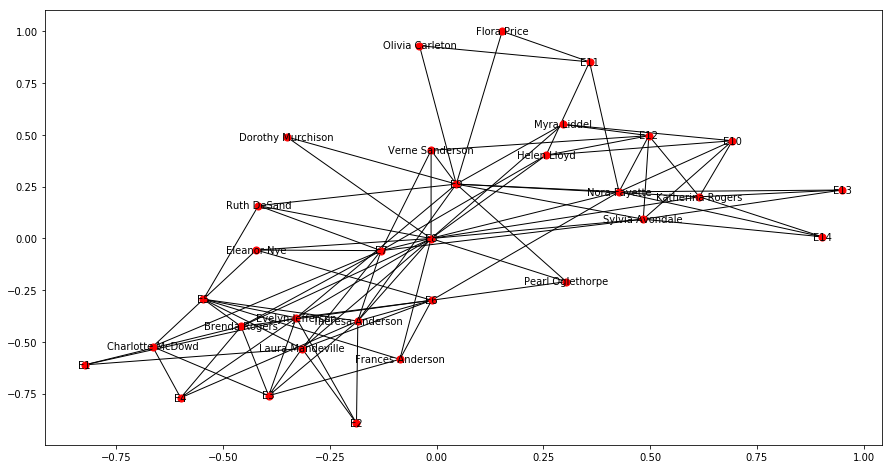

In [8]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random infection

In [9]:
labels = init_labels(G)
randomInfection = random_ranking(G)
#randomInfection

In [10]:
rand_eval = evaluate_spread(G, payoff_dict, randomInfection)

In [13]:
plot_distribution(rand_eval, "Random-Infection")

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



From the plot is clear that using a higher matrix payoff would help the contagion to spread, consequently requiring less time to reach the final state. In this case, using the equal chance pay-off matrix the end state is naturally never reached (requiring repeated infections).

### -- closeness guided infection

In [14]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [15]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [16]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [17]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [18]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [19]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [20]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [21]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [22]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [23]:
labels = init_labels(G)
ranked_clt = metric_ranking(nx.clustering, G)
#ranked_clt

In [24]:
clt_eval = evaluate_spread(G, payoff_dict, ranked_clt)

In [34]:
plot_distribution(clt_eval, "Clustering-guided")

### -- pagerank guided infection

In [26]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [27]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

In [32]:
plot_distribution(prk_eval, "Pagerank-guided")

### -- HITS (hubs=authorities) guided infection

In [29]:
labels = init_labels(G)
ranked_hit = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hit

In [30]:
hit_eval = evaluate_spread(G, payoff_dict, ranked_hit)

In [31]:
plot_distribution(hit_eval, "Hits-guided")

From these plots, it’s obvious that the contagion will require less time to spread to the whole graph: selecting the most important nodes (according to some centrality index) we could infect more neighbours in the first and subsequent steps, with lower structural impedance in the early stages.

Using the equal chance pay off matrix the best results in terms of time (or the number of infections in our model) are reached starting the contagion from the nodes with the highest clustering coefficients (spreading inside cliques).

## 2. Erdős-Rényi random graph [$G_{np}$]

In [35]:
n = 100

### 2.1  Subcritical regime $\left[p<\frac{1}{n}\right]$

In [40]:
G = nx.gnp_random_graph(n,1/(n*2))
pos = nx.spring_layout(G)
print("Average degree = {}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

Average degree = 0.5


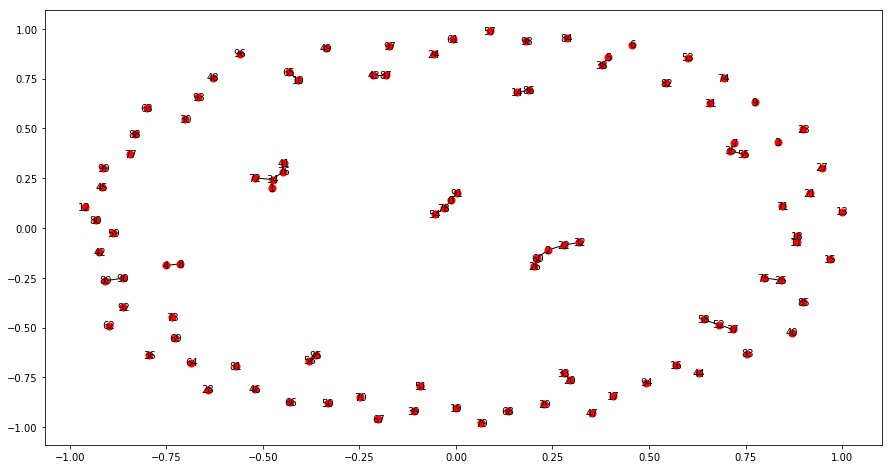

In [41]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [42]:
labels = init_labels(G)
randomInfection = random_ranking(G)
#randomInfection

In [43]:
rand_eval = evaluate_spread(G, payoff_dict, randomInfection)

In [44]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [45]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [46]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [47]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [48]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [49]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [50]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [51]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [52]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [53]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [54]:
labels = init_labels(G)
ranked_clt = metric_ranking(nx.clustering, G)
#ranked_cls

In [55]:
clt_eval = evaluate_spread(G, payoff_dict, ranked_clt)

In [56]:
plot_distribution(clt_eval, "Clustering-guided")

### -- pagerank guided infection

In [57]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [58]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

In [59]:
plot_distribution(prk_eval, "Pagerank-guided")

### -- HITS (hubs=authorities) guided infection

In [60]:
labels = init_labels(G)
ranked_hit = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hit

In [61]:
hit_eval = evaluate_spread(G, payoff_dict, ranked_hit)

In [62]:
plot_distribution(hit_eval, "Hits-guided")

Being composed of different tiny components the spread of infections cannot reach all the nodes: when the contagion stops, we repeatedly infect randomly another node; reaching the final stage requires a lot of time, whatever setting is being adopted (this is due to the architecture of this network).

### 2.2 Supercritical regime $\left[\frac{1}{n}<p<\frac{\log{n}}{n}\right]$

In [92]:
G = nx.gnp_random_graph(n,1.3/n)
pos = nx.spring_layout(G)
print("Average degree = {}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

Average degree = 1.36


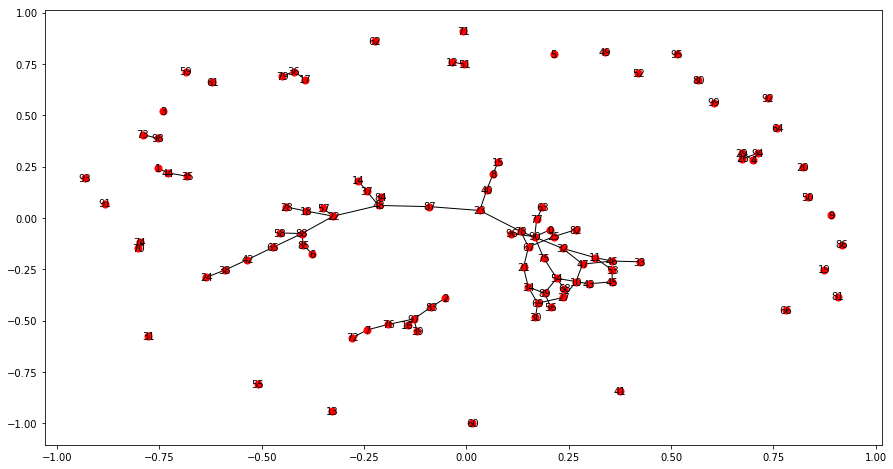

In [93]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

The giant component looks like a network (in the sense that it contains a finite fraction of the nodes): while numerous isolated aggregates are shaped like trees, the giant component contains loops and cycles.

### -- random infection

In [94]:
labels = init_labels(G)
randomInfection = random_ranking(G)
#randomInfection

In [95]:
rand_eval = evaluate_spread(G, payoff_dict, randomInfection)

In [96]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [97]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [98]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [99]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [100]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [101]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [102]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [103]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [104]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [105]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [106]:
labels = init_labels(G)
ranked_clt = metric_ranking(nx.clustering, G)
#ranked_cls

In [107]:
clt_eval = evaluate_spread(G, payoff_dict, ranked_clt)

In [108]:
plot_distribution(clt_eval, "Clustering-guided")

### -- pagerank guided infection

In [109]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [110]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

In [111]:
plot_distribution(prk_eval, "Pagerank-guided")

### -- HITS (hubs=authorities) guided infection

In [112]:
labels = init_labels(G)
ranked_hit = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hit

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:207: ComplexWarning:

Casting complex values to real discards the imaginary part

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:208: ComplexWarning:

Casting complex values to real discards the imaginary part



In [113]:
hit_eval = evaluate_spread(G, payoff_dict, ranked_hit)

In [114]:
plot_distribution(hit_eval, "Hits-guided")

Intuitively, different plots do not change evidently between a random setting and centrality-driven one: it suggests that the graph is still too disconnected and we cannot see relevant spreading behaviour. However, the discrepancy of the equal chance payoff matrix starts to emerge: it requires more time w.r.t the unbalanced matrices (that boost the spreading).

### 2.3 Connected regime $\left[p>\frac{\log{n}}{n}\right]$

In [118]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=4.72


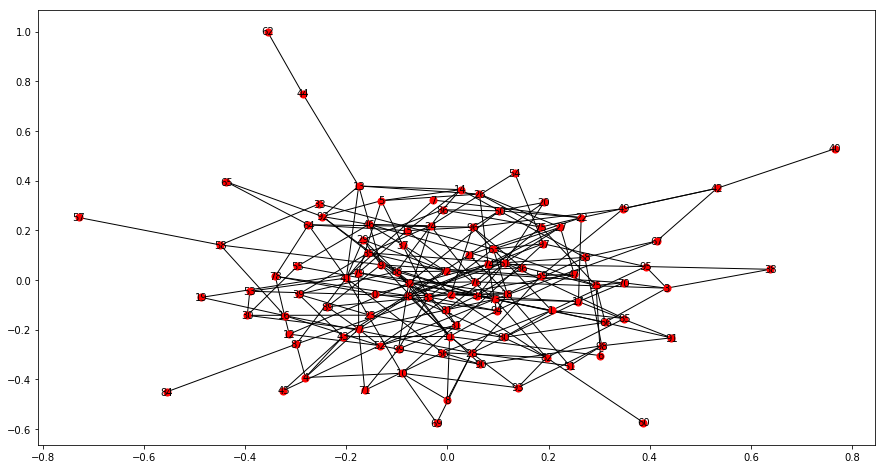

In [119]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

For sufficiently large  the giant component absorbs all the individuals: if isolated nodes are not present, the network is defined as connected.

### -- random infection

In [120]:
labels = init_labels(G)
randomInfection = random_ranking(G)
#randomInfection

In [121]:
rand_eval = evaluate_spread(G, payoff_dict, randomInfection)

In [122]:
plot_distribution(rand_eval, "Random-Infection")

Looking at the plot, we can see easily spot the differences: the equal chance contagion requires less time compared to the other regimes (subcritical and supercritical); similarly, the usage of increasingly unbalanced payoff matrices boosts the spreading rate and reduces the time required to infect everyone.

### -- closeness guided infection

In [123]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [124]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [125]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [126]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [127]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [128]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [129]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [130]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [131]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [132]:
labels = init_labels(G)
ranked_clt = metric_ranking(nx.clustering, G)
#ranked_clt

In [133]:
clt_eval = evaluate_spread(G, payoff_dict, ranked_clt)

In [134]:
plot_distribution(clt_eval, "Clustering-guided")

### -- pagerank guided infection

In [135]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [136]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

In [137]:
plot_distribution(prk_eval, "Pagerank-guided")

### -- HITS (hubs=authorities) guided infection

In [138]:
labels = init_labels(G)
ranked_hit = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hit

In [139]:
hit_eval = evaluate_spread(G, payoff_dict, ranked_hit)

In [140]:
plot_distribution(hit_eval, "Hits-guided")

With different choice as a starting point, we achieve better results (as expected): the measure that gives the best result with the equal payoff matrix is the PageRank.

## 3. Power law network

In [141]:
G = nx.barabasi_albert_graph(n,2)
pos = nx.spring_layout(G)

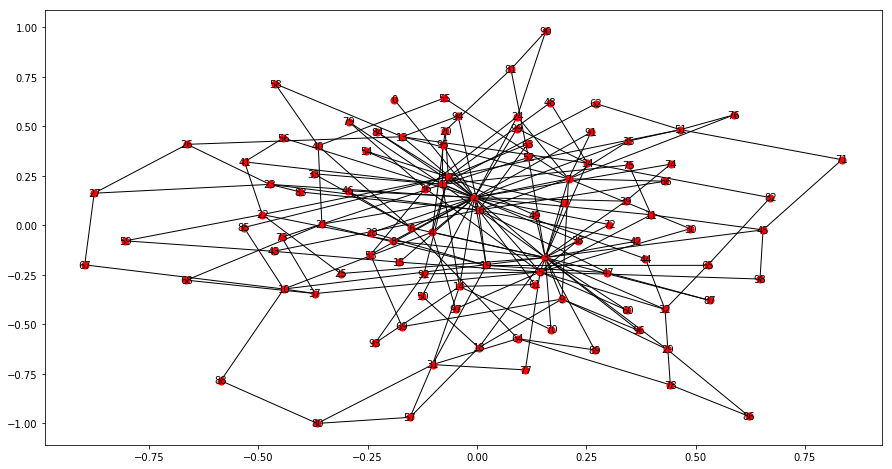

In [142]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [143]:
labels = init_labels(G)
randomInfection = random_ranking(G)
#randomInfection

In [144]:
rand_eval = evaluate_spread(G, payoff_dict, randomInfection)

In [145]:
plot_distribution(rand_eval, "Random-Infection")

The presence of hubs noticeably slows the pace of random infection: intuitively, the node majority possesses a low amount of connection, the random contagion is consequently very likely to pick a low-spread individual; unfair matrices, however, mitigate this natural impedance.

### -- closeness guided infection

In [146]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [147]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [148]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [149]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [150]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [151]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [152]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [153]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [154]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [155]:
labels = init_labels(G)
ranked_clt = metric_ranking(nx.clustering, G)
#ranked_clt

In [156]:
clt_eval = evaluate_spread(G, payoff_dict, ranked_clt)

In [157]:
plot_distribution(clt_eval, "Clustering-guided")

### -- pagerank guided infection

In [158]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [159]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

In [160]:
plot_distribution(prk_eval, "Pagerank-guided")

### -- HITS (hubs=authorities) guided infection

In [161]:
labels = init_labels(G)
ranked_hit = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hit

In [162]:
hit_eval = evaluate_spread(G, payoff_dict, ranked_hit)

In [163]:
plot_distribution(hit_eval, "Hits-guided")

The only measure that differs much from the others is clustering: this is due to the fact that this factor is related to the number of connected nodes as a clique (increasing  the time required to spread the infection using clustering coefficient as a centrality measure grows).

If we pause for a moment and think about the clustering coefficient driven contagion, it means that we’re trying to infect a highly connected component: in a clique, the susceptible nodes (not infected yet) act strongly against the spreading rate, so we will not see a break-out until the majority of nodes are infected, from which point, the entire connected component will act as a single hubs.

## 4. Real Graph - arXiv collaboration on general relativity

In [ ]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random infection

In [ ]:
labels = init_labels(G)
randomInfection = random_ranking(G)
#randomInfection

In [ ]:
rand_eval = evaluate_spread(G, payoff_dict, randomInfection)

In [ ]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [ ]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [ ]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [ ]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [ ]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [ ]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [ ]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [ ]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [ ]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [ ]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [ ]:
labels = init_labels(G)
ranked_clt = metric_ranking(nx.clustering, G)
#ranked_clt

In [ ]:
clt_eval = evaluate_spread(G, payoff_dict, ranked_clt)

In [ ]:
plot_distribution(clt_eval, "Clustering-guided")

### -- pagerank guided infection

In [ ]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [ ]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

In [ ]:
plot_distribution(prk_eval, "Pagerank-guided")

### -- HITS (hubs=authorities) guided infection

In [ ]:
labels = init_labels(G)
ranked_hit = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hit

In [ ]:
hit_eval = evaluate_spread(G, payoff_dict, ranked_hit)

In [ ]:
plot_distribution(hit_eval, "Hits-guided")